# RISEI Stability Experiment

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210329-111851
Wall time: 40 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8333333333333334
recall: 0.8064516129032258
f1-score: 0.819672131147541
support: 62


CN
precision: 0.7
recall: 0.7368421052631579
f1-score: 0.717948717948718
support: 38


micro avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


macro avg
precision: 0.7666666666666666
recall: 0.7716468590831917
f1-score: 0.7688104245481295
support: 100


weighted avg
precision: 0.7826666666666666
recall: 0.78
f1-score: 0.7810172341319883
support: 100


samples avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


F1
micro: 0.78
macro: 0.7688104245481295


accuracy_score: 0.78
sensitivity_score: 0.8064516129032258
specificity_score: 0.7368421052631579


Wall time: 30.1 s


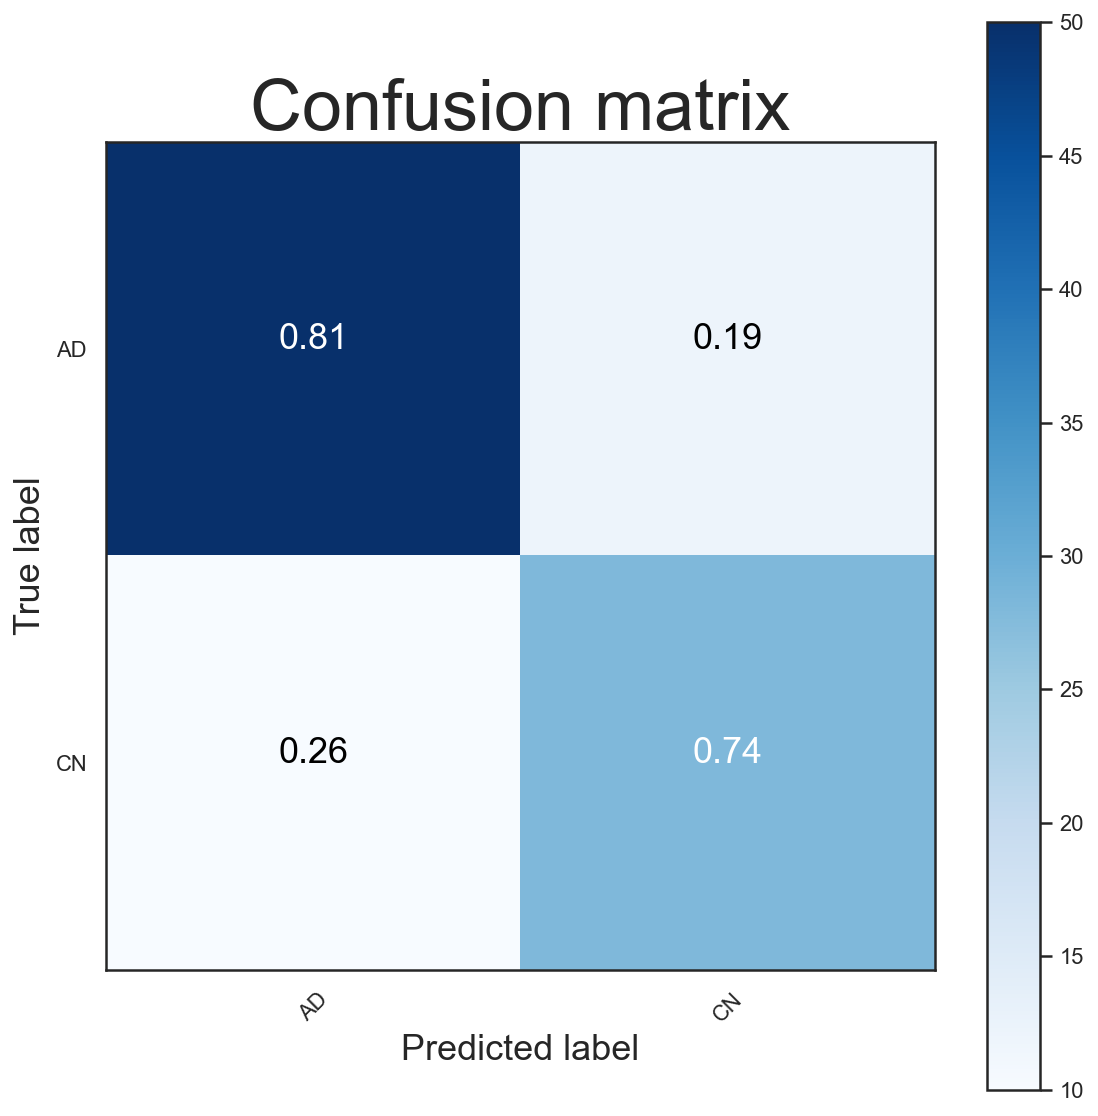

In [8]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

show_metrics(model, test_seq, class_names)

## RISEI

In [9]:
from src.risei import RISEI

### Config

In [10]:
risei_config = {
    's': 8, 
    'p1': 1/3, 
    'b1': 0,
    'b2': 1,
    'b2_value': 1,
    'in_paint': '2d', 
    'in_paint_blending': True, 
    'in_paint_radius': 5,
    'in_paint_2d_to_3d': True,
    'processes': 8,
}

### Evaluate

In [11]:
import time

from src.heatmaps.evaluation import get_heatmap

risei_batch_size = 480
risei = RISEI(input_shape[:-1], debug=False, **risei_config)

# we will test this only with one image
batch_x, batch_y, *_ = test_seq[0]
idx = 0
image_x, image_y = batch_x[idx], batch_y[idx]

In [12]:
from multiprocessing import Pool

from tqdm import tqdm


class Serializer():
    def __init__(self, n, input_shape, in_memory=True):
        self.n = n
        self.id = int(time.time())
        self.input_shape = input_shape
        self.save_dir = None
        
        if in_memory:
            self.save_dir = os.path.join(ROOT_DIR, "risei-stability-cache")
            os.makedirs(self.save_dir, exist_ok=True) # mkdir -p
        else:
            self.heatmaps = np.zeros((n, *input_shape[:-1]))
    
    def add_heatmap(self, i, heatmap):
        if self.save_dir is not None:
            np.save(self.__get_fname(i), heatmap)
        else:
            self.heatmaps[i] = heatmap
            
    def get_std(self, processes=8):
        if self.save_dir is not None:
            pass
            return std_heatmaps
        else:
            return get_std_heatmaps_v2(self.heatmaps) 
        
    def __get_fname(self, i):
        return get_fname(self.save_dir, self.id, i)
    
    
def __get_fname(save_dir, _id, i):
    return os.path.join(save_dir, f'hmap_{_id}_{i}.npy')

In [13]:
def generate_heatmaps(n, masks_count, image_x, image_y, tf_reset=2):
    serializer = Serializer(n, input_shape, False)

    i = 0
    while i < n:
        try:
            print(f"generating heatmap #{i}...")
            risei = RISEI(input_shape[:-1], debug=False, **risei_config)
            heatmap, _, _ = get_heatmap(
                image_x,
                image_y,
                model,
                risei,
                batch_size=train_config['batch_size'],
                masks_count=masks_count,
                risei_batch_size=risei_batch_size,
                debug=False,
                log=True
            )
            risei = None

            # save the heatmap to all generated heatmaps
            serializer.add_heatmap(i, heatmap)
            
            i = i + 1
            
            # https://github.com/tensorflow/tensorflow/issues/35010
            if i % tf_reset == 0:
                tf.keras.backend.clear_session()
        except Exception as e:
            print("there was an error, we will try to generate this heatmap again...")
            print(e)

    return serializer

def get_std_heatmaps_v1(heatmaps):
    std_heatmaps = np.zeros(input_shape[:-1])
    
    for z in range(heatmaps.shape[1]):
        for y in range(heatmaps.shape[2]):
            for x in range(heatmaps.shape[3]):
                # select the same voxel from all images
                voxels = heatmaps[:, z, y, x]
                # save the standard deviation for that voxel
                # TODO: optimize with axis param
                std_heatmaps[z, y, x] = np.std(voxels)
                
    return std_heatmaps

def get_std_heatmaps_v2(heatmaps):
    return np.std(heatmaps, axis=0)

In [14]:
# h1 = generate_heatmaps(10, 12, image_x, image_y)
# h2 = generate_heatmaps(10, 12, image_x, image_y)

In [14]:
def run(experiments, masks_counts):
    for masks_count in masks_counts:
        print(f"generating {experiments}x {masks_count} masks...")
        start = time.time()
        # [experiments, z, x, y]
        serializer = generate_heatmaps(experiments, masks_count, image_x, image_y)
        end = time.time()
        # [z, x, y]
        std_heatmaps = serializer.get_std()

        print(f"result for {masks_count} masks (t: {datetime.timedelta(seconds=int(end - start))})")
        print(f"\tmean std: {np.mean(std_heatmaps)}")
        print(f"\tmin std: {np.min(std_heatmaps)}")
        print(f"\tmax std: {np.max(std_heatmaps)}")
        print(f"\tstd std: {np.std(std_heatmaps)}")

        fPath = os.path.join(ROOT_DIR, "risei-stability")
        fName = os.path.join(fPath, f"{int(time.time())}_m{masks_count}.npy")
        os.makedirs(fPath, exist_ok=True) # mkdir -p
        print(f"saving std_heatmaps to {fName} ...")
        np.save(fName, std_heatmaps)

In [16]:
# experiments = 100
# masks_counts = [16, 128, 256, 512]

# run(experiments, masks_counts)

In [16]:
import tracemalloc

In [18]:
experiments = 100
masks_counts = [1024]

tracemalloc.start()

run(experiments, masks_counts)

Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating 100x 1024 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.74it/s]


generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #14...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #18...


Generating masks: 100%|██████████| 64/64 [00:04<00:00, 12.87it/s]


generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #24...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #25...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #26...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #27...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #28...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #29...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #30...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.70it/s]


generating heatmap #31...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #32...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #33...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #34...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #35...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #36...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #37...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #38...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #39...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #40...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #41...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #42...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.61it/s]


generating heatmap #43...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #44...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #45...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #46...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #47...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #48...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #49...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #50...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #51...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #52...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #53...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #54...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


generating heatmap #55...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #56...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #57...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #58...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #59...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #60...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #61...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #62...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #63...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #64...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #65...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #66...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.31it/s]


generating heatmap #67...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #68...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.51it/s]


generating heatmap #69...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #70...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.34it/s]


generating heatmap #71...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #72...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #73...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #74...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #75...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #76...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #77...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.36it/s]


generating heatmap #78...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #79...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #80...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #81...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #82...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #83...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #84...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #85...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #86...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #87...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #88...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #89...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 12.03it/s]


generating heatmap #90...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #91...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #92...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #93...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #94...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #95...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #96...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #97...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #98...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #99...


Generating masks: 100%|██████████| 64/64 [00:05<00:00, 11.76it/s]


result for 1024 masks (t: 2:20:02)
	mean std: 0.007945915119364023
	min std: 0.005760998324556283
	max std: 0.010459754446245204
	std std: 0.0005792769747603631
saving std_heatmaps to ../../../../tmp\risei-stability\1616440225_m1024.npy ...


In [19]:
# from pympler import asizeof
# a = np.zeros((1024, *input_shape[:-1]))
# asizeof.asizeof(a) / 1024 / 1024

In [19]:
import linecache


def display_top(snapshot, key_type='lineno', limit=300):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f MiB"
              % (index, filename, frame.lineno, stat.size / 1024 / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)
            
# snapshot = tracemalloc.take_snapshot()

# display_top(snapshot)

In [18]:
experiments = 100
masks_counts = [2048]

tracemalloc.start()

run(experiments, masks_counts)

Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating 100x 2048 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #14...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #18...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #24...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #25...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #26...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #27...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #28...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #29...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #30...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #31...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #32...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #33...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #34...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #35...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #36...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #37...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #38...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #39...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #40...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #41...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #42...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #43...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #44...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #45...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #46...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #47...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #48...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #49...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #50...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #51...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #52...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #53...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #54...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #55...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #56...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #57...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #58...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #59...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #60...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #61...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #62...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #63...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #64...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #65...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #66...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #67...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #68...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #69...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #70...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #71...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #72...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #73...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #74...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #75...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #76...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #77...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #78...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #79...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #80...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #81...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #82...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #83...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #84...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #85...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #86...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #87...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #88...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #89...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #90...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #91...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #92...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #93...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #94...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #95...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #96...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #97...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #98...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #99...


Generating masks: 100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


result for 2048 masks (t: 4:54:34)
	mean std: 0.005668415713692904
	min std: 0.004035326562707381
	max std: 0.007353847934063378
	std std: 0.00041544225814454385
saving std_heatmaps to ../../../../tmp\risei-stability\1616459705_m2048.npy ...


In [17]:
experiments = 50
masks_counts = [3072, 4096]

tracemalloc.start()

run(experiments, masks_counts)

Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating 50x 3072 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks: 100%|██████████| 192/192 [00:10<00:00, 17.56it/s]


generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks: 100%|██████████| 192/192 [00:11<00:00, 17.45it/s]


generating heatmap #14...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #18...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #24...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #25...


Generating masks: 100%|██████████| 192/192 [00:11<00:00, 16.07it/s]


generating heatmap #26...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #27...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #28...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #29...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #30...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #31...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #32...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #33...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #34...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #35...


Generating masks: 100%|██████████| 192/192 [00:12<00:00, 15.37it/s]


generating heatmap #36...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #37...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #38...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #39...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #40...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #41...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #42...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #43...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #44...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #45...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #46...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #47...


Generating masks: 100%|██████████| 192/192 [00:12<00:00, 14.97it/s]


generating heatmap #48...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #49...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

result for 3072 masks (t: 3:34:31)
	mean std: 0.004530022197964115
	min std: 0.0027128837459437154
	max std: 0.0065531617076287655
	std std: 0.0004514350781844201
saving std_heatmaps to ../../../../tmp\risei-stability\1616625059_m3072.npy ...
generating 50x 4096 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks: 100%|██████████| 256/256 [00:15<00:00, 16.75it/s]


generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks: 100%|██████████| 256/256 [00:16<00:00, 15.70it/s]


generating heatmap #14...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #18...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #24...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #25...


Generating masks: 100%|██████████| 256/256 [00:17<00:00, 14.65it/s]


generating heatmap #26...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #27...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #28...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #29...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #30...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #31...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #32...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #33...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #34...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #35...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #36...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #37...


Generating masks: 100%|██████████| 256/256 [00:17<00:00, 14.67it/s]


generating heatmap #38...


Generating masks:   0%|          | 0/480 [00:05<?, ?it/s]


there was an error, we will try to generate this heatmap again...
Unable to allocate 47.5 MiB for an array with shape (3, 120, 144, 120) and data type float64
generating heatmap #38...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #39...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #40...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #41...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #42...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #43...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #44...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #45...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #46...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #47...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #48...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #49...


Generating masks: 100%|██████████| 256/256 [00:17<00:00, 14.80it/s]


result for 4096 masks (t: 4:58:48)
	mean std: 0.003931406427998826
	min std: 0.002317307775280156
	max std: 0.005813656503826624
	std std: 0.000413862608921315
saving std_heatmaps to ../../../../tmp\risei-stability\1616642989_m4096.npy ...


In [18]:
experiments = 25
masks_counts = [6144, 8192]

run(experiments, masks_counts)

generating 25x 6144 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks: 100%|██████████| 384/384 [00:23<00:00, 16.31it/s]


generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks: 100%|██████████| 384/384 [00:23<00:00, 16.45it/s]


generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #14...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks: 100%|██████████| 384/384 [00:23<00:00, 16.17it/s]


generating heatmap #18...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks: 100%|██████████| 384/384 [00:23<00:00, 16.48it/s]


generating heatmap #24...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

result for 6144 masks (t: 3:41:39)
	mean std: 0.0031425511181114403
	min std: 0.001555348662011158
	max std: 0.004990408353835016
	std std: 0.00044097722771380067
saving std_heatmaps to ../../../../tmp\risei-stability\1616656291_m6144.npy ...
generating 25x 8192 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #14...


Generating masks: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


generating heatmap #15...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #16...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #17...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #18...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #19...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #20...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #21...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #22...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #23...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #24...


Generating masks: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


result for 8192 masks (t: 5:00:59)
	mean std: 0.002728395932053344
	min std: 0.0011858847650701506
	max std: 0.004137537421975953
	std std: 0.00039031023599813244
saving std_heatmaps to ../../../../tmp\risei-stability\1616674352_m8192.npy ...


In [15]:
experiments = 15
masks_counts = [16384]

run(experiments, masks_counts)

Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating 15x 16384 masks...
generating heatmap #0...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #1...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #5...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #6...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #7...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #8...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #9...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #10...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #11...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #12...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #13...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #14...


Generating masks: 100%|██████████| 64/64 [00:11<00:00,  5.68it/s]


result for 16384 masks (t: 5:50:09)
	mean std: 0.0018715354985120365
	min std: 0.0005514721951825148
	max std: 0.0034178110619230615
	std std: 0.0003572153903529152
saving std_heatmaps to ../../../../tmp\risei-stability\1616873762_m16384.npy ...


In [15]:
experiments = 5
masks_counts = [32768]

run(experiments, masks_counts)

Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating 5x 32768 masks...
generating heatmap #0...


Generating masks: 100%|██████████| 128/128 [00:08<00:00, 14.63it/s]


generating heatmap #1...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #2...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #3...


Generating masks:   0%|          | 0/480 [00:00<?, ?it/s]

generating heatmap #4...


Generating masks: 100%|██████████| 128/128 [00:11<00:00, 11.62it/s]


result for 32768 masks (t: 3:49:55)
	mean std: 0.0012085773665048824
	min std: 3.1672873658649065e-05
	max std: 0.003137882366710504
	std std: 0.00043409690648415545
saving std_heatmaps to ../../../../tmp\risei-stability\1617028970_m32768.npy ...
